In [ ]:
import zipfile
import os

# Paths
zip_path = '/content/data.zip'
extract_to = '/content/activity_data'  # Clear name for your dataset

print(f" Extracting {zip_path}...")
print(f"Size: {os.path.getsize(zip_path):,} bytes")

# Create extraction folder
os.makedirs(extract_to, exist_ok=True)

# Extract with progress info
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    print(f" Contains {len(file_list)} files/folders")

    # Show first few files
    print("\nFirst 10 files in ZIP:")
    for file in file_list[:10]:
        print(f"  • {file}")

    if len(file_list) > 10:
        print(f"  • ... and {len(file_list)-10} more")

    # Check for .dat files
    dat_files = [f for f in file_list if f.endswith('.dat')]
    print(f"\n Found {len(dat_files)} .dat files in ZIP")

    # Extract all files
    print(f"\n Extracting to {extract_to}...")
    zip_ref.extractall(extract_to)

print(" Extraction complete!")

 Extracting /content/data.zip...
Size: 531,873,142 bytes
 Contains 9 files/folders

First 10 files in ZIP:
  • subject101.dat
  • subject102.dat
  • subject103.dat
  • subject104.dat
  • subject105.dat
  • subject106.dat
  • subject107.dat
  • subject108.dat
  • subject109.dat

 Found 9 .dat files in ZIP

 Extracting to /content/activity_data...
 Extraction complete!


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

np.random.seed(42)


In [ ]:
DATA_PATH = "/content/activity_data/*.dat"

columns = (
    ["timestamp", "activity", "heart_rate"] +
    [f"hand_{i}" for i in range(1, 18)] +
    [f"chest_{i}" for i in range(1, 18)] +
    [f"ankle_{i}" for i in range(1, 18)]
)

dfs = []

files = glob.glob(DATA_PATH)
print(f"Found {len(files)} .dat files")

for f in files:
    subject_id = int(os.path.basename(f).replace("subject", "").replace(".dat", ""))
    df = pd.read_csv(f, sep=" ", header=None)
    df.columns = columns
    df["subject"] = subject_id
    dfs.append(df)
    print(f"Loaded subject {subject_id}: {len(df)} rows")

data = pd.concat(dfs, ignore_index=True)
print("Total samples:", len(data))


Found 9 .dat files
Loaded subject 107: 313599 rows
Loaded subject 109: 8477 rows
Loaded subject 101: 376417 rows
Loaded subject 106: 361817 rows
Loaded subject 105: 374783 rows
Loaded subject 108: 408031 rows
Loaded subject 104: 329576 rows
Loaded subject 102: 447000 rows
Loaded subject 103: 252833 rows
Total samples: 2872533


In [ ]:
data = data[data["activity"] != 0].reset_index(drop=True)
print("After removing transient:", len(data))


After removing transient: 1942872


In [ ]:
# Heart rate: forward fill
data["heart_rate"] = data["heart_rate"].ffill()

# IMU data interpolation
imu_cols = data.columns[3:-1]
data[imu_cols] = data[imu_cols].interpolate()

# Drop any remaining NaNs
data = data.dropna().reset_index(drop=True)

print("After NaN handling:", len(data))


After NaN handling: 1942867


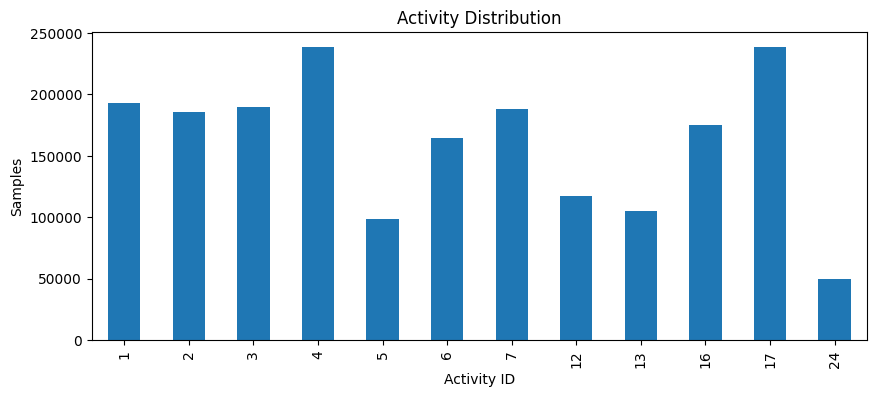

In [ ]:
plt.figure(figsize=(10,4))
data["activity"].value_counts().sort_index().plot(kind="bar")
plt.title("Activity Distribution")
plt.xlabel("Activity ID")
plt.ylabel("Samples")
plt.show()


In [ ]:
FEATURES = [
    "heart_rate",
    "hand_2", "hand_3", "hand_4",
    "chest_2", "chest_3", "chest_4",
    "ankle_2", "ankle_3", "ankle_4"
]

X = data[FEATURES].values
y = data["activity"].values
subjects = data["subject"].values


In [ ]:
gss = GroupShuffleSplit(
    test_size=0.2,
    n_splits=1,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups=subjects))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
WINDOW = 256
STRIDE = 128

def create_windows(X, y, window, stride):
    X_w, y_w = [], []
    for i in range(0, len(X) - window, stride):
        X_w.append(X[i:i+window])
        y_w.append(np.bincount(y[i:i+window]).argmax())
    return np.array(X_w), np.array(y_w)

X_train_w, y_train_w = create_windows(X_train, y_train, WINDOW, STRIDE)
X_test_w, y_test_w = create_windows(X_test, y_test, WINDOW, STRIDE)

print("Train windows:", X_train_w.shape)
print("Test windows:", X_test_w.shape)


Train windows: (11072, 256, 10)
Test windows: (4104, 256, 10)


In [ ]:
def extract_features(X):
    return np.hstack([
        X.mean(axis=1),
        X.std(axis=1),
        X.min(axis=1),
        X.max(axis=1)
    ])

X_train_feat = extract_features(X_train_w)
X_test_feat = extract_features(X_test_w)

print("Final feature shape:", X_train_feat.shape)


Final feature shape: (11072, 40)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_w)
y_test_enc = le.transform(y_test_w)

num_classes = len(le.classes_)
print("Classes:", le.classes_)


Classes: [ 1  2  3  4  5  6  7 12 13 16 17 24]


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)

class_weight_dict = {
    i: class_weights[i] for i in range(len(class_weights))
}


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_feat, y_train_enc)


RandomForestClassifier(class_weight={0: np.float64(0.8157972295903331),
                                     1: np.float64(0.8433881779402803),
                                     2: np.float64(0.8496009821976673),
                                     3: np.float64(0.675946275946276),
                                     4: np.float64(1.6272780717225162),
                                     5: np.float64(1.0367041198501872),
                                     6: np.float64(0.9126277612924497),
                                     7: np.float64(1.3410852713178294),
                                     8: np.float64(1.4762666666666666),
                                     9: np.float64(0.905462872096827),
                                     10: np.float64(0.6671487105326585),
                                     11: np.float64(4.331768388106417)},
                       n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf.predict(X_test_feat)

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_.astype(str)
))


Accuracy: 0.8486842105263158
              precision    recall  f1-score   support

           1       0.98      0.95      0.97       371
           2       0.97      0.79      0.87       354
           3       0.87      0.93      0.90       397
           4       0.66      0.96      0.78       501
           5       0.96      0.91      0.94       201
           6       0.98      0.96      0.97       395
           7       1.00      0.44      0.61       458
          12       0.75      0.84      0.79       228
          13       0.65      0.63      0.64       193
          16       0.84      0.93      0.88       351
          17       0.83      0.95      0.88       483
          24       1.00      0.84      0.91       172

    accuracy                           0.85      4104
   macro avg       0.87      0.84      0.84      4104
weighted avg       0.87      0.85      0.84      4104



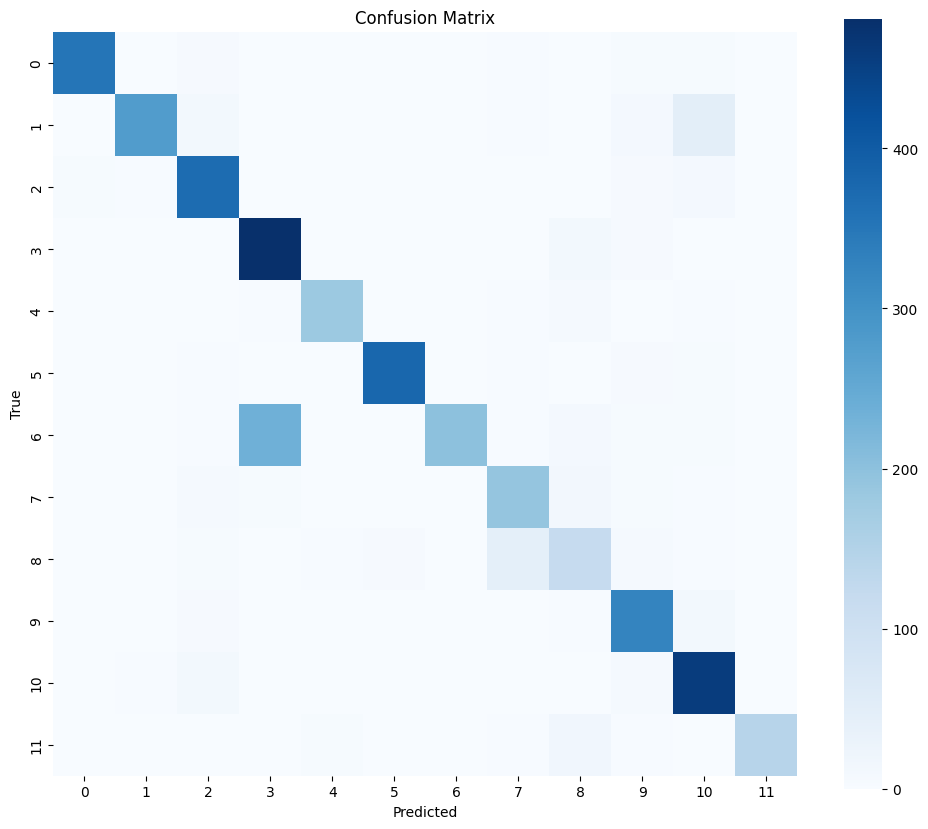

In [ ]:
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
